In [28]:
import gym
import random
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# 게임 환경 생성
env = gym.make('CartPole-v1')

# Q-Network 모델 생성
model = Sequential()
model.add(Dense(24, input_shape=(4,), activation='relu'))
model.add(Dense(24, activation='relu'))
model.add(Dense(2, activation='linear'))
model.compile(loss='mse', optimizer=Adam(lr=0.001))

# 학습 파라미터 설정
epsilon = 1.0  # 탐험 비율
epsilon_decay = 0.995  # 탐험 비율 감소율
gamma = 0.95  # 할인 계수
batch_size = 32  # 미니배치 크기
memory = []  # 리플레이 메모리

# DQN 학습 함수
def train_model():
    global epsilon
    batch = random.sample(memory, batch_size)

    for state, action, reward, next_state, done in batch:
        target = reward

        if not done:
            target = reward + gamma * np.amax(model.predict(np.array([next_state]))[0])

        target_f = model.predict(np.array([state]))
        target_f[0][action] = target

        model.fit(np.array([state]), target_f, epochs=1, verbose=0)

    if epsilon > 0.01:
        epsilon *= epsilon_decay

# 게임 실행 및 학습
episodes = 1000

for episode in range(episodes):
    state = env.reset()[0]
    done = False
    score = 0

    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(model.predict(np.array([state]))[0])

        next_state, reward, done, _, _= env.step(action)
        score += reward
        memory.append((state, action, reward, next_state, done))
        state = next_state

        if len(memory) > batch_size:
            train_model()

    print(f"Episode: {episode + 1}, Score: {score}, Epsilon: {epsilon:.2f}")

# 학습된 모델로 게임 플레이
state = env.reset()
done = False
score = 0

while not done:
    action = np.argmax(model.predict(np.array([state]))[0])
    next_state, reward, done, _ = env.step(action)
    state = next_state
    score += reward

env.close()
print(f"Final Score: {score}")


1/1 [==============================] - 0s 22ms/step
Episode: 1, Score: 35.0, Epsilon: 0.99
1/1 [==============================] - 0s 24ms/step


KeyboardInterrupt: 

In [29]:
import gym
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# 게임 환경 생성
env = gym.make('CartPole-v1')

# Q-Network 모델 생성
model = Sequential()
model.add(Dense(24, input_shape=(4,), activation='relu'))
model.add(Dense(24, activation='relu'))
model.add(Dense(2, activation='linear'))
model.load_weights('dqn_cartpole.h5')  # 학습된 모델 불러오기

# 게임 플레이
state = env.reset()
done = False
score = 0

while not done:
    action = np.argmax(model.predict(np.array([state]))[0])
    next_state, reward, done, _ = env.step(action)
    state = next_state
    score += reward

env.close()
print(f"Final Score: {score}")


FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'dqn_cartpole.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

c:\Users\jakek\anaconda3\envs\proj4\lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


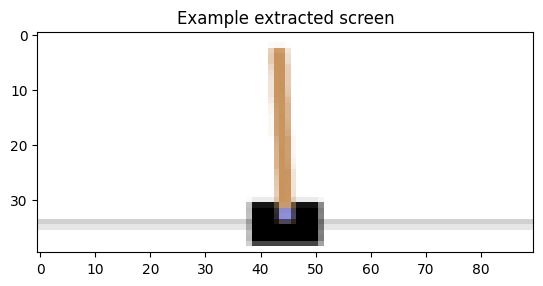

In [30]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

# gym에서 wrappers option을 설정하면 영상 저장이 가능하다.
env = gym.make('CartPole-v0', render_mode='rgb_array').unwrapped

# matplotlib 설정
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

# interactive-on, 그때 그때 plot을 갱신하는 option
plt.ion()

# device 설정
# GPU를 사용할 수 있으면 사용하고, 아니면 CPU를 사용한다.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


# ReplayMemory를 정의
class ReplayMemory(object):
    def __init__(self, capacity):
        # deque는 양방향 queue를 의미한다.
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        # Transition을 저장하는 부분이다.
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        # memory로부터 batch_size 길이 만큼의 list를 반환한다.
        return random.sample(self.memory, batch_size)

    def __len__(self):
        # memory의 길이를 반환한다.
        return len(self.memory)
    
class DQN(nn.Module):
    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        # Linear layer input의 차원을 맞춰주기 위한 함수이다.
        # Conv2d layer의 연산 과정을 생각하여 size를 계산한다.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        # 계산한 size에 output channel 개수인 32를 곱해 차원을 맞춰준다.
        self.head = nn.Linear(linear_input_size, outputs)

    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        rst = self.head(x.view(x.size(0), -1))
        # 아래와 같은 형식의 output을 얻을 수 있다. (선택지 2개)
        # rst >> tensor([[2.0840, 2.0001]])
        return rst
    
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=T.InterpolationMode.BICUBIC),
                    T.ToTensor()])

def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

def get_screen():
    # gym이 요청한 화면은 400x600x3 이지만, 가끔 800x1200x3 처럼 큰 경우가 있습니다.
    # 이것을 Torch order (CHW)로 변환한다.
    screen = env.render().transpose((2, 0, 1))
    # 카트는 아래쪽에 있으므로 화면의 상단과 하단을 제거하십시오.
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # 카트를 중심으로 정사각형 이미지가 되도록 가장자리를 제거하십시오.
    screen = screen[:, :, slice_range]
    # float 으로 변환하고,  rescale 하고, torch tensor 로 변환하십시오.
    # (이것은 복사를 필요로하지 않습니다)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # 크기를 수정하고 배치 차원(BCHW)을 추가하십시오.
    return resize(screen).unsqueeze(0)

# 예제 patch를 출력해볼 수 있는 부분
env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

In [31]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

# initial screen을 설정한다.
init_screen = get_screen()

# init_screen.shape >> torch.Size([1, 3, 40, 90])
_, _, screen_height, screen_width = init_screen.shape

# gym의 action space에서 action의 가짓수를 얻는다.
# n_actions >> 2
n_actions = env.action_space.n

# 여기서 network의 구성은 DQN(40, 90, 2) 이다.
policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)

# policy network의 network parameter를 불러온다.   
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())

# Capacity (즉, maximum length) 10000짜리 deque 이다.
memory = ReplayMemory(10000)
steps_done = 0

def select_action(state):
    # Global 변수로 선언한다.
    global steps_done
    # random.random() >> [0.0, 1.0) 구간의 소수점 숫자를 반환한다.
    sample = random.random()
    # steps_done이 커짐에 따라 epsilon 값이 줄어든다. 
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
    math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1

    if sample > eps_threshold:
        with torch.no_grad():
            # 기댓값이 더 큰 action을 고르자. 
            # 바로 예를 들어 설명해보면, 아래의 논리로 코드가 진행된다.
            '''
            policy_net(state) >> tensor([[0.5598, 0.0144]])
            policy_net(state).max(1) >> ('max value', 'max 값의 index')
            policy_net(state).max(1)[1] >> index를 선택함.
            policy_net(state).max(1)[1].view(1, 1) >> tensor([[0]]) 
            '''
            # 즉, 위 예제의 경우 index 0에 해당하는 action을 선택하는 것이다.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        # tensor([['index']])의 형식으로 random하게 action이 선택된다. 
        # 즉, 0 이나 1 값이 선택됨.
        return torch.tensor([[random.randrange(n_actions)]], device=device, \
        dtype=torch.long)
episode_durations = []

def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # 100개 에피소드의 평균을 가져 와서 도표 그리기
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # 도표가 업데이트되도록 잠시 멈춤
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())
        
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return

    # 여기서부터는 memory의 길이 (크기)가 BATCH_SIZE 이상인 경우이다.
    # BATCH_SIZE의 크기만큼 sampling을 진행한다.  
    transitions = memory.sample(BATCH_SIZE)

    # Remind) Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))
    # 아래의 코드를 통해 batch에는 각 항목 별로 BATCH_SIZE 개수 만큼의 성분이 한번에 묶여 저장된다.
    batch = Transition(*zip(*transitions))

    # 우선 lambda가 포함된 line의 빠른 이해를 위해 다음의 예제를 보자. 
    # list(map(lambda x: x ** 2, range(5))) >> [0, 1, 4, 9, 16]
    '''
    즉, 아래의 line을 통해 BATCH_SIZE 개의 원소를 가진 tensor가 구성된다.  
    또한 각 원소는 True와 False 로 구성되어 있다. 
    batch.next_state는 다음 state 값을 가지고 있는 tensor로 크게 두 부류로 구성된다.
    >> None 혹은 torch.Size([1, 3, 40, 90]) 의 형태
    '''
    # 정리하면 아래의 코드는 batch.next_state에서 None을 갖는 원소를 False로, 
    # 그렇지 않으면 True를 matching 시키는 line이다.
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    
    # batch.next_state의 원소들 중 next state가 None이 아닌 원소들의 집합이다. 
    # torch.Size(['next_state가 None이 아닌 원소의 개수', 3, 40, 90])의 형태
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])

    # 아래 세 변수의 size는 모두 torch.Size([128, 3, 40, 90]) 이다. 
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # torch.gather(input, dim, index, *, sparse_grad=False, out=None) → Tensor
    # action_batch 에 들어있는 0 혹은 1 값으로 index를 설정하여 결과값에서 가져온다.
    # 즉, action_batch 값에 해당하는 결과 값을 불러온다.  
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # 한편, non_final_next_states의 행동들에 대한 기대값은 "이전" target_net을 기반으로 계산됩니다.

    # 일단 모두 0 값을 갖도록 한다.  
    next_state_values = torch.zeros(BATCH_SIZE, device=device)

    # non_final_mask에서 True 값을 가졌던 원소에만 값을 넣을 것이고, False 였던 원소에게는 0 값을 유지할 것이다. 
    # target_net(non_final_next_states).max(1)[0].detach() 를 하면, 
    # True 값을 갖는 원소의 개수만큼 max value 값이 모인다.  
    # 이들을 True 값의 index 위치에만 반영시키도록 하자.
    # 정리하면 한 state에서 더 큰 action을 선택한 것에 대한 value 값이 담기게 된다.  
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()

    # expected Q value를 계산하자.  
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Huber Loss 계산
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize parameters
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        # 모든 원소를 [ min, max ]의 범위로 clamp
        param.grad.data.clamp_(-1, 1)
    optimizer.step()
    
# batch = Transition(*zip(*transitions)) 

# state_action_values = policy_net(state_batch).gather(1, action_batch)

In [32]:
num_episodes = 20
for i_episode in range(num_episodes):
    # env와 state를 초기화 한다.  
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    
    # 여기서 사용한 count()는 from itertools import count 로 import 한 것이다. 
    # t -> 0, 1, 2, ... 의 순서로 진행된다.  
    for t in count():
        # state shape >> torch.Size([1, 3, 40, 90]) 
        # action result >> tensor([[0]]) or tensor([[1]])
        action = select_action(state)

        # 선택한 action을 대입하여 reward와 done을 얻어낸다. 
        # env.step(action.item())의 예시  
        # >> (array([-0.008956, -0.160571,  0.005936,  0.302326]), 1.0, False, {})
        _, reward, done, _, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        # 새로운 state를 구해보자.  
        last_screen = current_screen
        # action이 반영된 screen을 얻어낸다. 
        current_screen = get_screen()

        if not done:
            next_state = current_screen - last_screen
        else: # 만약, done이 True라면 그만하자. 
            next_state = None

        # 얻어낸 transition set을 memory에 저장
        memory.push(state, action, next_state, reward)

        # 다음 상태로 이동
        state = next_state

        # (policy network에서) 최적화 한단계 수행
        optimize_model()

        # 마찬가지로 done이 True 라면,
        if done:
            # 하나의 episode가 몇 번 진행 되었는지 counting 하는 line
            episode_durations.append(t + 1)
            plot_durations()
            plt.show()
            break
    
    # TARGET_UPDATE 마다 target network의 parameter를 update 한다. 
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

    # (episode 한번에 대한) 전체 for문 1회 종료.
    print(i_episode+1,'회 완료')

# 학습 마무리. 
print('Complete')
env.render()
env.close()
plt.ioff()
plt.show()

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

20 회 완료
Complete


In [34]:
import gym
import random
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = []
        self.gamma = 0.95  # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.learning_rate = 0.001
        self.model = self.build_model()

    def build_model(self):
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:1
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

if __name__ == "__main__":
    env = gym.make('CartPole-v1')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    agent = DQNAgent(state_size, action_size)

    batch_size = 32
    episodes = 1000
    for e in range(episodes):
        state = env.reset()[0]
        # state = np.reshape(state, [1, state_size])
        for time in range(500):
            action = agent.act(state)
            next_state, reward, done, _,_ = env.step(action)
            reward = reward if not done else -10
            next_state = next_state
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            if done:
                print("episode: {}/{}, score: {}, e: {:.2}"
                      .format(e, episodes, time, agent.epsilon))
                break
            if len(agent.memory) > batch_size:
                agent.replay(batch_size)


c:\Users\jakek\anaconda3\envs\proj4\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


ValueError: in user code:

    File "c:\Users\jakek\anaconda3\envs\proj4\lib\site-packages\keras\engine\training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\jakek\anaconda3\envs\proj4\lib\site-packages\keras\engine\training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\jakek\anaconda3\envs\proj4\lib\site-packages\keras\engine\training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\jakek\anaconda3\envs\proj4\lib\site-packages\keras\engine\training.py", line 2111, in predict_step
        return self(x, training=False)
    File "c:\Users\jakek\anaconda3\envs\proj4\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\jakek\anaconda3\envs\proj4\lib\site-packages\keras\engine\input_spec.py", line 253, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_8' (type Sequential).
    
    Input 0 of layer "dense_24" is incompatible with the layer: expected min_ndim=2, found ndim=1. Full shape received: (None,)
    
    Call arguments received by layer 'sequential_8' (type Sequential):
      • inputs=tf.Tensor(shape=(None,), dtype=float32)
      • training=False
      • mask=None
